In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import torch
from torch.utils.data import Dataset
from model_protein_vec import trans_basic_block, trans_basic_block_Config
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import pickle

from sklearn import svm
import faiss
import os # accessing directory structure

/mnt/home/thamamsy/projects/protein_vec/lib/environment/protein_vec_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

model = model.to(device)
model = model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_PFAM_negative_mining/checkpoints/epoch=0-step=37100-val_loss=0.0016.ckpt'
vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_PFAM_negative_mining/params.json'

#Load the model
vec_model_config = trans_basic_block_Config.from_json(vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(vec_model_cpnt, config=vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

In [5]:
def featurize_prottrans(sequences, model, tokenizer, device): 
    
    sequences = [(" ".join(sequences[i])) for i in range(len(sequences))]
    sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()

    features = [] 
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        features.append(seq_emd)
    
    prottrans_embedding = torch.tensor(features[0])
    prottrans_embedding = torch.unsqueeze(prottrans_embedding, 0).to(device)
    
    return(prottrans_embedding)


#Embed a protein using tm_vec (takes as input a prottrans embedding)
def embed_vec(prottrans_embedding, model_deep, device):
    padding = torch.zeros(prottrans_embedding.shape[0:2]).type(torch.BoolTensor).to(device)
    vec_embedding = model_deep(prottrans_embedding, src_mask=None, src_key_padding_mask=padding)
    return(vec_embedding.cpu().detach().numpy())


def tokenize(sequences, tokenizer):
    sequences = [(" ".join(sequences[i])) for i in range(len(sequences))]
    sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)['input_ids']
    return(torch.tensor(ids))

In [25]:
data_partitions_dirpath = '/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/cluster_split/'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('cluster_test')
dev = read_all_shards('cluster_dev')
train = read_all_shards('cluster_train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Available dataset partitions:  ['cluster_split_all_pfam_names_with_embedding_train_dev.npy', 'cluster_dev', 'cluster_split_all_pfam_to_embed_prottrans.csv', 'Pfam-A.clans.tsv', 'cluster_train', 'uniprot-compressed_true_download_true_fields_accession_2Cid_2Cdate_c-2023.04.21-19.24.21.42.tsv', 'cluster_split_all_pfam_names.npy', 'cluster_test']
Dataset partition "test" has 21293 sequences
Dataset partition "dev" has 21510 sequences
Dataset partition "train" has 1283272 sequences


In [9]:
flat_seqs = test['sequence'].values

In [ ]:
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_vec(protrans_sequence, model_deep, device)
    embed_all_sequences.append(embedded_sequence)
    i = i + 1
    
    if i % 500 == 0:
        print(i)

In [10]:
embeddings_np = np.concatenate(embed_all_sequences, axis=0)

In [ ]:
#write_path = '/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/pfam_embeddings/embeddings_pfam_test_negative_mining.npy'
#np.save(write_path, embeddings_np)

In [11]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_np)
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df.columns = ["Dim1", "Dim2"]

In [12]:
X_embedded_df['Entry'] = test['family_accession'][0:len(embeddings_np)].values

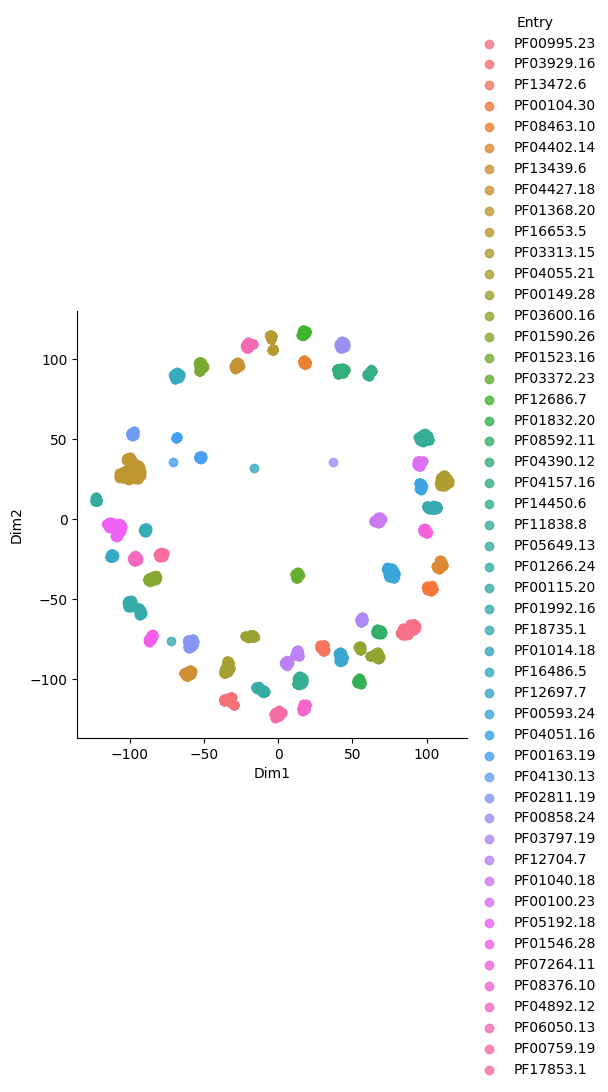

In [13]:
top_pfams = list(test['family_accession'].value_counts()[0:50].index)
X_embedded_df = X_embedded_df[X_embedded_df['Entry'].isin(top_pfams)]

#Visualize the TSNE, coloring by EC level
sns.lmplot(x="Dim1", y="Dim2", data=X_embedded_df, hue="Entry", fit_reg=False)

# Now perform search

In [3]:
#Load the lookup embeddings
look_embeddings = np.float32(np.load('/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/pfam_embeddings/embeddings_pfam_all_in_one_hard_negative.npy'))


In [14]:
#If we make queries from the above embeddings
#query_embedding = np.float32(embeddings_np)


In [4]:
#otherwise load the query embeddings (make sure the same model was used for the queries as for the lookup)
query_embedding = np.float32(np.load('/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/pfam_embeddings/embeddings_pfam_test_negative_mining.npy'))


In [13]:
look_embeddings.shape

(1304782, 1024)

In [14]:
def query(index, queries, k=10):
    faiss.normalize_L2(queries)
    D, I = index.search(queries, k)

    return(D, I)

def load_database(lookup_database):
    #Build an indexed database
    d = lookup_database.shape[1]
    index = faiss.IndexFlatIP(d)
    faiss.normalize_L2(lookup_database)
    index.add(lookup_database)

    return(index)

In [15]:
index = load_database(look_embeddings)
D, I = query(index, query_embedding, 1)

In [18]:
#Load the metadata for the lookup embeddings
combined_trained_dev = pd.read_csv('/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/cluster_split_combined_train_dev.csv', sep="\t")                             
training_pfam = pd.DataFrame(np.load('/mnt/home/thamamsy/ceph/protein_vec/data/PFAM/cluster_split/cluster_split_all_pfam_names_with_embedding_train_dev.npy'))
lookup_metadata = pd.DataFrame(training_pfam).merge(combined_trained_dev, left_on=0, right_on='sequence_name')
lookup_metadata_pfam = lookup_metadata['family_accession'].values
unique_lookup_pfams = np.unique(lookup_metadata_pfam)

In [22]:
len(unique_lookup_pfams)

17925

In [23]:
#Get metadata for the nearest neighbors
near_ids = []
for i in range(I.shape[0]):
    meta = lookup_metadata_pfam[I[i]]
    near_ids.append(list(meta))       

near_ids = np.array(near_ids)

In [111]:
#Calculate the accuracy and error rates
num_correct = np.sum(test['family_accession'].values == near_ids[:,0])
print("Accuracy rate: ")
print(num_correct/len(test))

Accuracy rate: 
0.9480110834546565
